# XGBoost

In [1]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

First, we load the data:

In [2]:
import os
cwd = os.getcwd()
parent = os.path.dirname(cwd) # .../Latest-News-Classifier/0. Latest News Classifier

# Dataframe
path_df = parent + "/03. Feature Engineering/Pickles/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = parent + "/03. Feature Engineering/Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = parent + "/03. Feature Engineering/Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = parent + "/03. Feature Engineering/Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = parent + "/03. Feature Engineering/Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

Let's check the dimension of our feature vectors:

In [3]:
print(features_train.shape)
print(features_test.shape)

(1891, 300)
(334, 300)


## Cross-Validation for Hyperparameter tuning

First, we can see what hyperparameters the model has:

In [4]:
xgb_0 = xgb.XGBClassifier(random_state=8)


print('Parameters currently in use:\n')
pprint(xgb_0.get_params())

Parameters currently in use:

{'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'binary:logistic',
 'random_state': 8,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}


We'll tune the following ones:

Tree-related hyperparameters:
* `n_estimators` = number of trees in the forest.
* `max_depth` = max number of levels in each decision tree
* `max_delta_step` = max delta step we allow each leaf output to be. If it is set to a positive value, it can help making the update step more conservative

Boosting-related hyperparameters:
* `learning_rate`= learning rate shrinks the contribution of each tree by learning_rate.
* `subsample`= the fraction of samples to be used for fitting the individual base learners.

XGBoost [API Reference](https://xgboost.readthedocs.io/en/latest/python/python_intro.html#data-interface), [Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)

### Randomized Search Cross Validation

We first need to define the grid. Since we have a huge amount of hyperparameters, we'll try few values for each one.

In [5]:
# n_estimators
n_estimators = [200, 500, 800]

# max_depth
max_depth = [10, 20, 40]
max_depth.append(None)

# max_delta_step
max_delta_step = [1, 5, 10, None]

# learning rate
learning_rate = [.1, .5]

# subsample
subsample = [.5, 1.]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_delta_step': max_delta_step,
               'learning_rate': learning_rate,
               'subsample': subsample}

pprint(random_grid)

{'learning_rate': [0.1, 0.5],
 'max_delta_step': [1, 5, 10, None],
 'max_depth': [10, 20, 40, None],
 'n_estimators': [200, 500, 800],
 'subsample': [0.5, 1.0]}


Then, we'll perform the Random Search:

In [8]:
# First create the base model to tune
xgbc = xgb.XGBClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=xgbc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 40.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_w..._pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=None, verbosity=None),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_estimators': [200, 500, 800], 'max_depth': [10, 20, 40, None], 'max_delta_step': [1, 5, 10, None], 'learning_rate': [0.1, 0.5], 'subsample': [0.5, 1.0]},
          pre_dispatch='2*n_jobs', random_state=8, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=1)

We can see the best hyperparameters resulting from the Random Search:  

In [9]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'subsample': 0.5, 'n_estimators': 200, 'max_depth': 40, 'max_delta_step': 1, 'learning_rate': 0.1}

The mean accuracy of a model with these hyperparameters is:
0.951348492861


After that, we can do a more exhaustive search centered in those values:

### Grid Search Cross Validation

In [ ]:
# Create the parameter grid based on the results of random search 
max_depth = [20, 40, 50]
n_estimators = [200, 500]
max_delta_step = [1.0]
learning_rate = [.1, .5]
subsample = [.5]

param_grid = {
    'max_depth': max_depth,
    'max_delta_step': max_delta_step,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'subsample': subsample

}

# Create a base model
xgbc = xgb.XGBClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xgbc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The best hyperparameters turn out to be:

In [12]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'learning_rate': 0.1, 'max_delta_step': 1.0, 'max_depth': 20, 'n_estimators': 200, 'subsample': 0.5}

The mean accuracy of a model with these hyperparameters is:
0.950933333333


Let's save the model in `best_xgbc`:

In [13]:
best_xgbc = grid_search.best_estimator_

In [14]:
best_xgbc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.1, max_delta_step=1.0, max_depth=20,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=200, n_jobs=0, num_parallel_tree=1,
       objective='multi:softprob', random_state=8, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=None, subsample=0.5,
       tree_method='exact', validate_parameters=1, verbosity=None)

We now know the best gradient boosting model. Let's fit it and see how it performs:

## Model fit and performance

Now, we can fit the model to our training data:

In [15]:
best_xgbc.fit(features_train, labels_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.1, max_delta_step=1.0, max_depth=20,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=200, n_jobs=0, num_parallel_tree=1,
       objective='multi:softprob', random_state=8, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=None, subsample=0.5,
       tree_method='exact', validate_parameters=1, verbosity=None)

And get the predictions:

In [16]:
xgbc_pred = best_xgbc.predict(features_test)

The conditional class probabilities can be obtained by typing:

`xgbc_pred = best_xgbc.predict_proba(features_test)`

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

#### Training accuracy

In [17]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_xgbc.predict(features_train)))

The training accuracy is: 
1.0


#### Test accuracy

In [18]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, xgbc_pred))

The test accuracy is: 
0.934131736527


#### Classification report

In [19]:
# Classification report
print("Classification report")
print(classification_report(labels_test,xgbc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        81
           1       0.96      0.96      0.96        49
           2       0.95      0.85      0.90        72
           3       0.99      0.97      0.98        72
           4       0.92      0.95      0.93        60

   micro avg       0.93      0.93      0.93       334
   macro avg       0.94      0.94      0.94       334
weighted avg       0.94      0.93      0.93       334



#### Confusion matrix

In [ ]:
aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, xgbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

```python
features_time = features_train
elapsed_list = []
for i in range(0,10):
    
    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
```

Let's see if the hyperparameter tuning process has returned a better model:

In [18]:
base_model = xgb.XGBClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.91317365269461082

In [19]:
best_xgbc.fit(features_train, labels_train)
accuracy_score(labels_test, best_xgbc.predict(features_test))

0.93712574850299402

We'll create a dataset with a model summary to compare models:

In [20]:
d = {
     'Model': 'XGBoost',
     'Training Set Accuracy': accuracy_score(labels_train, best_xgbc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, xgbc_pred)
}

df_models_gbc = pd.DataFrame(d, index=[0])

In [21]:
df_models_xgbc

,Model,Training Set Accuracy,Test Set Accuracy
0,Gradient Boosting,1.0,0.937126


Let's save the model and this dataset:

In [22]:
with open('Models/best_xgbc.pickle', 'wb') as output:
    pickle.dump(best_xgbc, output)
    
with open('Models/df_models_xgbc.pickle', 'wb') as output:
    pickle.dump(df_models_xgbc, output)

Evaluate the top features based on the impurity-based feature importances.

The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

In [23]:
# labels_test
path_tfidf = parent + "/03. Feature Engineering/Pickles/tfidf.pickle"
with open(path_tfidf, 'rb') as data:
    tfidf = pickle.load(data)


indices = np.argsort(best_xgbc.feature_importances_)[-50:]
feature_names = np.array(tfidf.get_feature_names())[indices]
print(feature_names[::-1])

['company' 'star' 'bank' 'film' 'win' 'computer' 'game' 'growth' 'labour'
 'online' 'user' 'digital' 'blair' 'use' 'party' 'award' 'technology'
 'minister' 'include' 'match' 'software' 'team' 'tory' 'government' 'music'
 'mr' 'show' 'prime' 'firm' 'market' 'mr blair' 'business' 'election'
 'side' 'analyst' 'player' 'release' 'chance' 'people' 'year old' 'england'
 'rise' 'tv' 'economy' 'pc' 'however' 'club' 'video' 'mobile' 'uk']


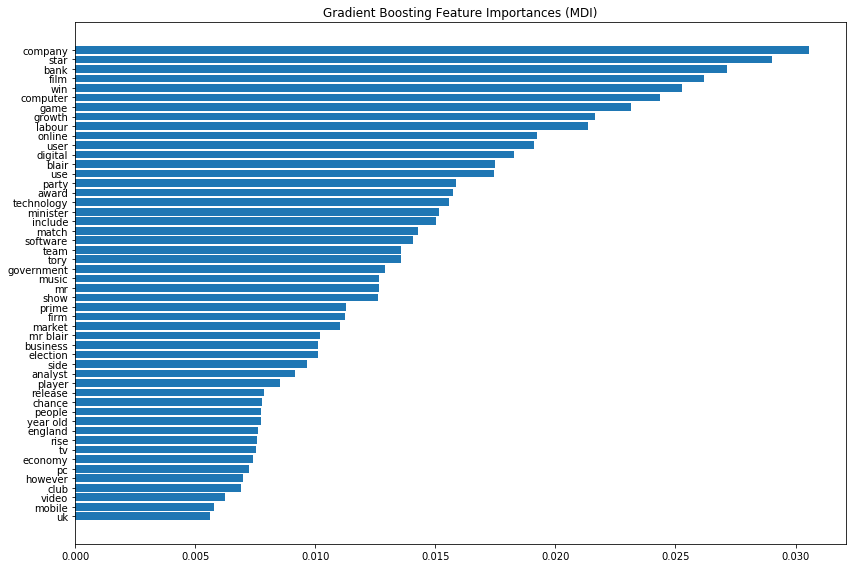

In [24]:
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(y_ticks, best_xgbc.feature_importances_[indices])
ax.set_yticklabels(feature_names)
ax.set_yticks(y_ticks)
ax.set_title("XGBoost Feature Importances (MDI)")
fig.tight_layout()
plt.show()